# Simulation 13: ILP vs. SG Wiopt

TJ Kim
8/7/20

Run the first simulation with the following considerations.

- 5 Servers, 5 TS, 6 Users
- Use Crawdad mobility
- Servers have limited resources, links have high resources
- All jobs are 5 TS long
- We share the same users and jobs

Resources: Limited
- All jobs are run with standard Quantity
- All servers are level 2
- Cores have been tweaked to [3,5] at all servers

In [13]:
from IPython.core.debugger import set_trace

# Import Generic Classes
import numpy as np
import copy
import pickle
import random

# Import All Custom Classes
import os, sys
sys.path.append(os.path.pardir+"/classes")
sys.path.append(os.path.pardir+"/solvers")
sys.path.append(os.path.pardir+"/one_mobility")
sys.path.append(os.path.curdir + "/sim_store/sim13")
sys.path.append(os.path.pardir+"/crawdad_mobility")


from Server import *
from User import *
from Link import *
from Job import *
from Migration_Plans import *
from Cost_Recordings import *

from load_crawdad_usr import *

from sim13_setting import *


# Import Solver Classes
from Optim_PlanGenerator import *
from SeqGreedy_PlanGenerator import *
from Myopic_PlanGenerator import *
from Naive_PlanGenerator import *
from Cloud_PlanGenerator import *

In [14]:
# Load Crawdad data
# Load All 12 users and trim their info
db_names = []
for i in range(1,2):
    db_names += ['LifeMap_GS'+str(i)+'.db']

db = []
for name in db_names:
    name = '/home/tkim/CMU/MEC_research/crawdad_mobility/' + name
    df,trace = load_usr(name)
    db += [trace]

### Run 10 Trials

Iteratively run trials x 10 and store the cost data for each the ILP and the SG models.

In [15]:
num_trials = 3
ILP_cost_stores_lim = []
SG_cost_stores_lim = []

ILP_cost_stores_ample = []
SG_cost_stores_ample = []

for i in range(num_trials):
    
    print("Trial Number:",i)
    
    # Make Users
    users, servers, links, jobs, sim_param = simulation_setting(db,'limited')
    
    # Make ILP and Optim Prob
    print("Generating lim Optim_Prob...")
    optim_prob_lim = Optim_PlanGenerator(users, servers, links, jobs, sim_param)
    print("Finished_Generating_ lim prob...")
    
    # Solve the problem and get the migration plan 
    optim_prob_lim.prob.solve()
    print("Status:", constants.LpStatus[optim_prob_lim.prob.status])
    ILP_mig_plan_lim = Migration_Plans(users, jobs, sim_param) 
    ILP_mig_plan_lim.from_ILP(optim_prob_lim)
    
    ILP_cost_stores_lim += [Cost_Recordings(ILP_mig_plan_lim)]
    
    
    # Make SG Prob
    print("Generating lim SG...")
    SG_prob_lim = SeqGreedy_PlanGenerator(users, servers, links, jobs, sim_param)
    SG_plan_lim = Migration_Plans(users,jobs,sim_param)
    SG_plan_lim.from_seq_greedy(SG_prob_lim)
    
    SG_cost_stores_lim += [Cost_Recordings(SG_plan_lim)]
    print("Done lim SG...")
    
    # Run ample
    for s in servers:
        s.avail_rsrc = np.ones(s.avail_rsrc.shape) * 1000
        
    # Make ILP and Optim Prob
    print("Generating ample Optim_Prob...")
    optim_prob_ample = Optim_PlanGenerator(users, servers, links, jobs, sim_param)
    print("Finished_Generating_ ample prob...")
    
    # Solve the problem and get the migration plan 
    optim_prob_ample.prob.solve()
    print("Status:", constants.LpStatus[optim_prob_ample.prob.status])
    ILP_mig_plan_ample = Migration_Plans(users, jobs, sim_param) 
    ILP_mig_plan_ample.from_ILP(optim_prob_ample)
    
    ILP_cost_stores_ample += [Cost_Recordings(ILP_mig_plan_ample)]
    
    
    # Make SG Prob
    print("Generating ample SG...")
    SG_prob_ample = SeqGreedy_PlanGenerator(users, servers, links, jobs, sim_param)
    SG_plan_ample = Migration_Plans(users,jobs,sim_param)
    SG_plan_ample.from_seq_greedy(SG_prob_ample)
    
    SG_cost_stores_ample += [Cost_Recordings(SG_plan_ample)]
    print("done ample SG...")


Trial Number: 0
Generating lim Optim_Prob...
Finished_Generating_ lim prob...
Status: Optimal
Generating lim SG...
Struck Placement Resource (j,s,t): 1 1 1
Struck Placement Resource (j,s,t): 1 1 2
Struck Placement Resource (j,s,t): 1 1 3
Struck Placement Resource (j,s,t): 1 1 4
Struck Placement Resource (j,s,t): 1 1 0
Struck Placement Resource (j,s,t): 3 0 0
Struck Placement Resource (j,s,t): 3 0 1
Struck Placement Resource (j,s,t): 3 1 2
Struck Placement Resource (j,s,t): 3 1 3
Struck Placement Resource (j,s,t): 3 1 4
Done lim SG...
Generating ample Optim_Prob...
Finished_Generating_ ample prob...
Status: Optimal
Generating ample SG...
done ample SG...
Trial Number: 1
Generating lim Optim_Prob...
Finished_Generating_ lim prob...
Status: Optimal
Generating lim SG...
Struck Placement Resource (j,s,t): 2 0 0
Struck Placement Resource (j,s,t): 2 0 1
Struck Placement Resource (j,s,t): 2 0 2
Struck Placement Resource (j,s,t): 2 0 3
Struck Placement Resource (j,s,t): 2 0 4
Struck Placement R

Run for ample scenario

### Plot the average or total cost and subcost

8 bars in total one for ILP one for SG
- Total Cost
- Placement cost
- Bandwidth Cost
- User Experience Cost

In [16]:
num_trials = len(ILP_cost_stores_lim)

# Log the costs of interest
ILP_total_sum_lim = np.zeros(num_trials)
ILP_placement_sum_lim = np.zeros(num_trials)
ILP_bw_sum_lim = np.zeros(num_trials)
ILP_UE_sum_lim = np.zeros(num_trials)

SG_total_sum_lim = np.zeros(num_trials)
SG_placement_sum_lim = np.zeros(num_trials)
SG_bw_sum_lim = np.zeros(num_trials)
SG_UE_sum_lim = np.zeros(num_trials)

ILP_total_sum_ample = np.zeros(num_trials)
ILP_placement_sum_ample = np.zeros(num_trials)
ILP_bw_sum_ample = np.zeros(num_trials)
ILP_UE_sum_ample = np.zeros(num_trials)

SG_total_sum_ample = np.zeros(num_trials)
SG_placement_sum_ample = np.zeros(num_trials)
SG_bw_sum_ample = np.zeros(num_trials)
SG_UE_sum_ample = np.zeros(num_trials)


for i in range(num_trials):
    ILP_total_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["total_cost"][-1]
    ILP_placement_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["placement_cost"][-1]
    ILP_bw_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["srv_bw_cost"][-1]
    ILP_bw_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["mig_bw_cost"][-1]
    ILP_UE_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["thruput_cost"][-1]
    ILP_UE_sum_lim[i] += ILP_cost_stores_lim[i].all_cost_cumulative["latency_cost"][-1]
    
    SG_total_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["total_cost"][-1]
    SG_placement_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["placement_cost"][-1]
    SG_bw_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["srv_bw_cost"][-1]
    SG_bw_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["mig_bw_cost"][-1]
    SG_UE_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["thruput_cost"][-1]
    SG_UE_sum_lim[i] += SG_cost_stores_lim[i].all_cost_cumulative["latency_cost"][-1]
    
    ILP_total_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["total_cost"][-1]
    ILP_placement_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["placement_cost"][-1]
    ILP_bw_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["srv_bw_cost"][-1]
    ILP_bw_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["mig_bw_cost"][-1]
    ILP_UE_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["thruput_cost"][-1]
    ILP_UE_sum_ample[i] += ILP_cost_stores_ample[i].all_cost_cumulative["latency_cost"][-1]
    
    SG_total_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["total_cost"][-1]
    SG_placement_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["placement_cost"][-1]
    SG_bw_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["srv_bw_cost"][-1]
    SG_bw_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["mig_bw_cost"][-1]
    SG_UE_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["thruput_cost"][-1]
    SG_UE_sum_ample[i] += SG_cost_stores_ample[i].all_cost_cumulative["latency_cost"][-1]



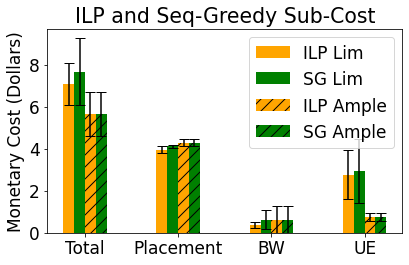

In [21]:
# Plot the plot
import matplotlib
import matplotlib.pyplot as plt

# Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

# Set Labels
labels = ['Total', 'Placement', 'BW', 'UE']

# Obtain Values to Plot
ILP_means_lim = [np.mean(ILP_total_sum_lim), np.mean(ILP_placement_sum_lim), np.mean(ILP_bw_sum_lim), np.mean(ILP_UE_sum_lim)]
SG_means_lim = [np.mean(SG_total_sum_lim), np.mean(SG_placement_sum_lim), np.mean(SG_bw_sum_lim), np.mean(SG_UE_sum_lim)]

ILP_vars_lim = [np.std(ILP_total_sum_lim), np.std(ILP_placement_sum_lim), np.std(ILP_bw_sum_lim), np.std(ILP_UE_sum_lim)]
SG_vars_lim = [np.std(SG_total_sum_lim), np.std(SG_placement_sum_lim), np.std(SG_bw_sum_lim), np.std(SG_UE_sum_lim)]

ILP_means_ample = [np.mean(ILP_total_sum_ample), np.mean(ILP_placement_sum_ample), np.mean(ILP_bw_sum_ample), np.mean(ILP_UE_sum_ample)]
SG_means_ample = ILP_means_ample
SG_means_ample = [np.mean(SG_total_sum_ample), np.mean(SG_placement_sum_ample), np.mean(SG_bw_sum_ample), np.mean(SG_UE_sum_ample)]

ILP_vars_ample = [np.std(ILP_total_sum_ample), np.std(ILP_placement_sum_ample), np.std(ILP_bw_sum_ample), np.std(ILP_UE_sum_ample)]
SG_vars_ample = [np.std(SG_total_sum_ample), np.std(SG_placement_sum_ample), np.std(SG_bw_sum_ample), np.std(SG_UE_sum_ample)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x = x - width/2, height =  ILP_means_lim, yerr = ILP_vars_lim,
                capsize = 5, width = width/3, label='ILP Lim', color='orange')
rects2 = ax.bar(x = x - width/6, height = SG_means_lim, yerr = SG_vars_lim, 
                capsize = 5, width = width/3, label='SG Lim', color = 'green')
rects3 = ax.bar(x = x + width/6, height =  ILP_means_ample, yerr = ILP_vars_ample,
                capsize = 5, width = width/3, label='ILP Ample', color='orange',hatch='//')
rects4 = ax.bar(x = x + width/2, height = SG_means_ample, yerr = SG_vars_ample, 
                capsize = 5, width = width/3, label='SG Ample', color = 'green',hatch='//')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Monetary Cost (Dollars)')
ax.set_title('ILP and Seq-Greedy Sub-Cost')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Set Y axis to zero
plt.ylim(0,)

fig.tight_layout()

plt.show()

### Pickle Result for Reproduction

In [6]:
import pickle

cost_stores_dic_lim = {}
cost_stores_dic_lim["SG"] = SG_cost_stores_lim
cost_stores_dic_lim["ILP"] = ILP_cost_stores_lim

cost_stores_dic_ample = {}
cost_stores_dic_ample["SG"] = SG_cost_stores_ample
cost_stores_dic_ample["ILP"] = ILP_cost_stores_ample


pickle.dump(cost_stores_dic_lim, open(os.path.curdir + "/sim_store/sim13/cost_store_lim_v1.p", "wb" ) )
pickle.dump(cost_stores_dic_ample, open(os.path.curdir + "/sim_store/sim13/cost_store_ample_v1.p", "wb" ) )


